In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import time

from PyDemoMomentumopt import MotionPlanner
from momentumopt.kinoptpy.momentum_kinematics_optimizer import MomentumKinematicsOptimizer

from quadruped.quadruped_wrapper import QuadrupedWrapper
QuadrupedWrapper.use_v3 = True

def replay_kinematic_plan():
    for ks in motion_planner.kin_optimizer.kinematics_sequence.kinematics_states:
        q = ks.robot_posture.generalized_joint_positions
        motion_planner.kin_optimizer.robot.display(np.matrix(q).T)
        time.sleep(0.1)

In [2]:
# cfg_file = '../config/SAB_Demos/cfg_quadruped_forward_jump.yaml'
# cfg_file = '../config/cfg_demo01_walk_short.yaml'
# cfg_file = '../config/cfg_demo02_trot_continous.yaml'
cfg_file = '../config/cfg_demo02_trot_continous.yaml'
# cfg_file = '../config/cfg_demo02_trot_continous_take01.yaml'
# cfg_file = '../config/cfg_demo02_trot_continous_take02.yaml'
# cfg_file = '../config/cfg_quadruped_lift_rear.yaml'
# cfg_file = '../config/cfg_quadruped_lift_leg_momentum.yaml'
# cfg_file = '../config/cfg_quadruped_lift_leg_momentum_rotated.yaml'

motion_planner = MotionPlanner(cfg_file)
inv_kin = motion_planner.kin_optimizer.inv_kin
kin_opt = motion_planner.kin_optimizer

motion_planner.ini_state.effPosition(0)

# Dynamic optimization
motion_planner.optimize_dynamics(0)
# optimized_kin_plan, optimized_motion_eff, optimized_dyn_plan, planner_setting, time_vector = motion_planner.optimize_motion()

('urdf', '/Users/jviereck/dev/kino-dynamics-opt-catkin/workspace/src/catkin/control/kino-dynamic-opt/momentumopt/src/urdf/quadruped.urdf')
('package_dirs', ['/Users/jviereck/dev/kino-dynamics-opt-catkin/workspace/src/catkin/control/kino-dynamic-opt/momentumopt/src'])
('DynOpt', 0)
('Dynopt - ', 6.343996047973633)


/Users/jviereck/dev/kino-dynamics-opt-catkin/workspace/src/catkin/control/kino-dynamic-opt/momentumopt/src/quadruped/quadruped_wrapper.py:43: DeprecatedWarning: Using deprecated instance variable Model.neutralConfiguration. Please use Model.referenceConfigurations instead.
  self.q = self.robot.model.neutralConfiguration.copy()


('KinOpt', 0)
Found initial configuration after 22 iterations


/Users/jviereck/dev/kino-dynamics-opt-catkin/workspace/src/catkin/control/kino-dynamic-opt/momentumopt/src/momentumopt/kinoptpy/momentum_kinematics_optimizer.py:243: DeprecatedWarning: Using deprecated instance variable Model.neutralConfiguration. Please use Model.referenceConfigurations instead.
  q = self.robot.model.neutralConfiguration.copy()


('kinopt - ', 0.6477911472320557)


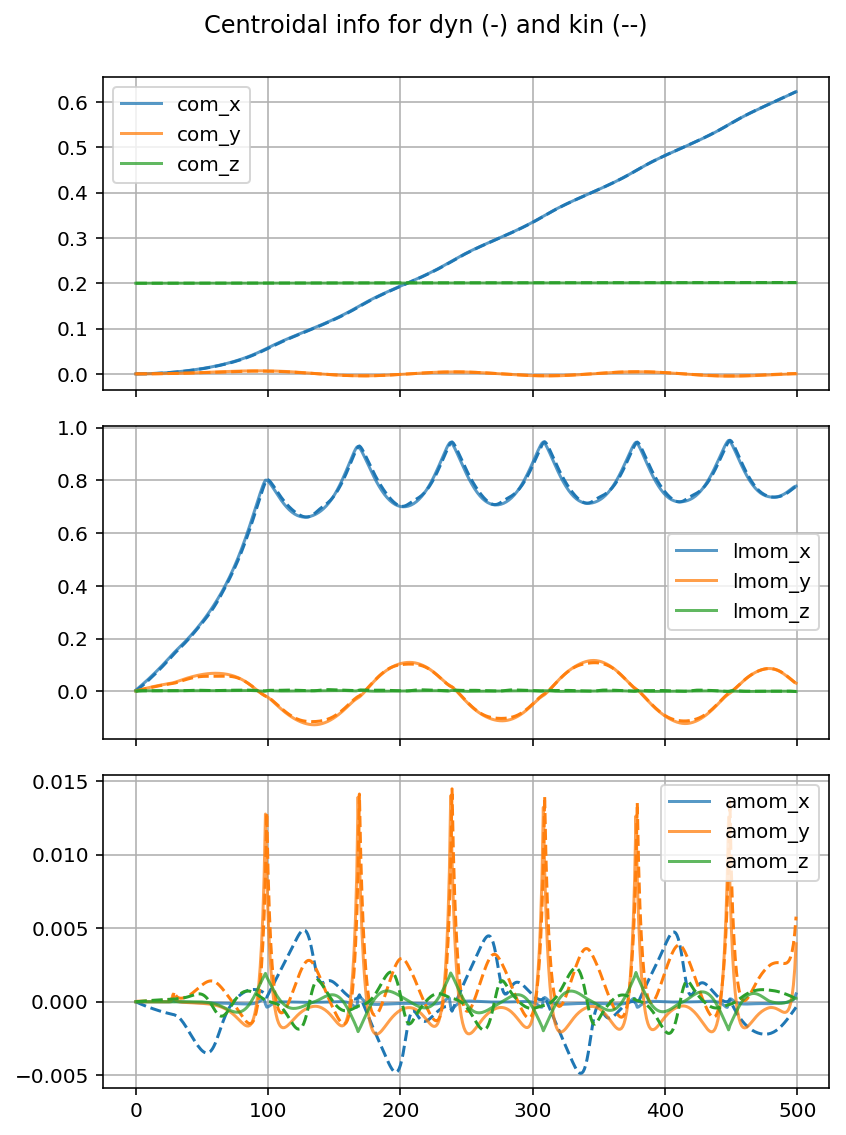

<Figure size 432x288 with 0 Axes>

In [3]:
etg = motion_planner.kin_optimizer.endeff_traj_generator
etg.z_offset = 0.1

inv_kin.w_com_tracking[:3] = 1.
inv_kin.w_com_tracking[3:] = 10.
# inv_kin.w_com_tracking[4] = 10.
inv_kin.w_endeff_contact = 1.
inv_kin.p_endeff_tracking = 1.
inv_kin.p_com_tracking = 1.
motion_planner.kin_optimizer.reg_orientation = 0.05

motion_planner.optimize_kinematics(0)
motion_planner.plot_centroidal()
# motion_planner.replay_kinematics()
plt.savefig('iter_00.pdf')

('DynOpt', 0)
('Dynopt - ', 9.441090106964111)
('KinOpt', 0)
('kinopt - ', 0.6072909832000732)


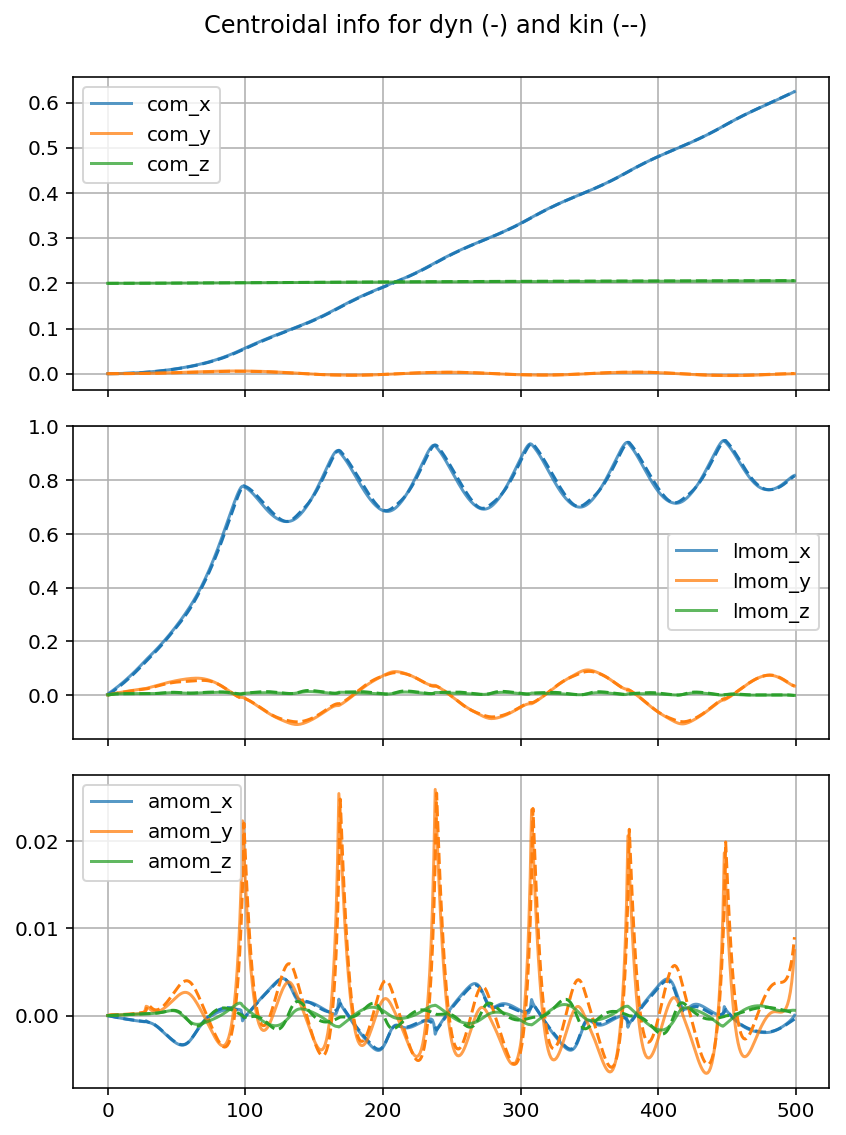

('DynOpt', 1)
('Dynopt - ', 16.38280200958252)
('KinOpt', 1)
('kinopt - ', 0.7148470878601074)


<Figure size 432x288 with 0 Axes>

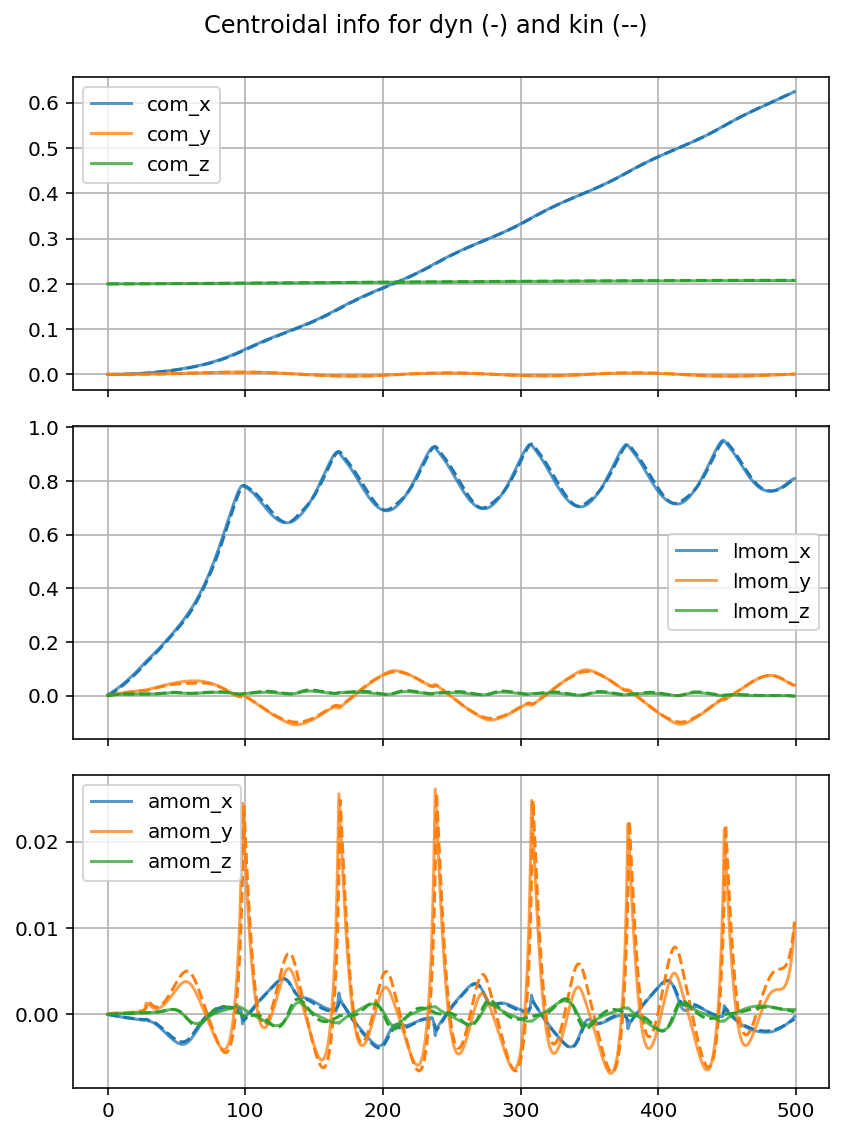

('DynOpt', 2)
('Dynopt - ', 15.289911985397339)
('KinOpt', 2)
('kinopt - ', 0.5790309906005859)


<Figure size 432x288 with 0 Axes>

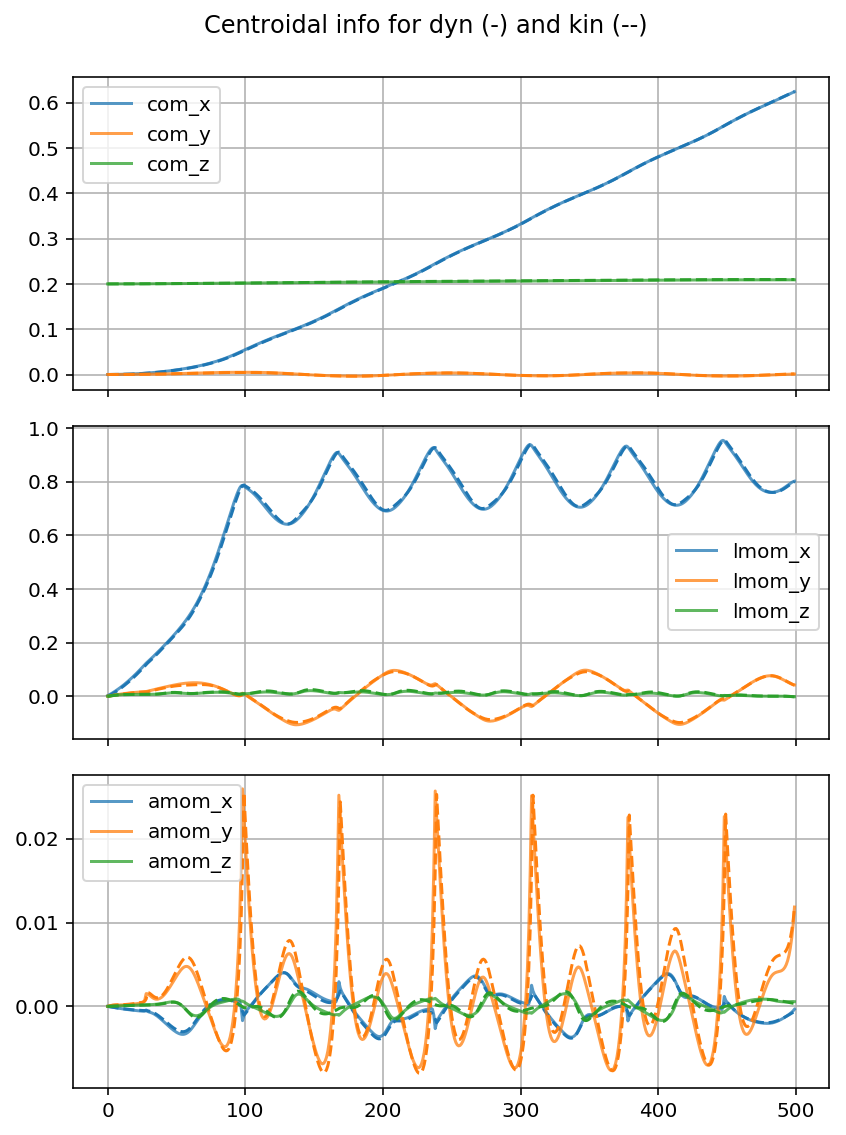

('max_time:', 3)
(3000, 36)
saving trajectories....


<Figure size 432x288 with 0 Axes>

In [5]:
for i in range(3):
    motion_planner.optimize_dynamics(i)
    motion_planner.kin_optimizer.reg_orientation = 0.05

    motion_planner.optimize_kinematics(i)
    motion_planner.plot_centroidal()
#     motion_planner.replay_kinematics()
    plt.savefig('iter_%02d.pdf' % (i))
    
motion_planner.optimize_dynamics_feedback()
    
motion_planner.save_files()

In [ ]:
### %load_ext autoreload
%autoreload 2

import pinocchio as se3
from pinocchio.utils import zero

import yaml
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=2)

import momentumopt
from quadruped.quadruped_wrapper import QuadrupedWrapper
from cpp_dynamics_simulator import cpp_dynamics_simulator

import time
import os
import pinocchio as se3
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm



dt = 0.001                      # controller time step
DISPLAY_N = 25                  # update robot configuration in viwewer every DISPLAY_N time steps

read_data = lambda filename, skip=1: np.genfromtxt(filename)[:, skip:]

desired = {
    'q': read_data('quadruped_generalized_positions.dat'),
    'dq': read_data('quadruped_generalized_velocities.dat'),
#     'ddq': read_data('quadruped_generalized_acceleration.dat'),
    'forces': read_data('quadruped_forces.dat').reshape(-1, 4, 3),
    'beff_pos':  read_data('quadruped_positions_eff_old.dat').reshape(-1, 4, 3),
    'beff_vel':  read_data('quadruped_velocities_eff_old.dat').reshape(-1, 4, 3),
    'lqr': read_data('quadruped_lqr_old.dat', 0).reshape(-1, 12, 9),
    'com': read_data('quadruped_com_old.dat').reshape(-1, 3),
    'lmom': read_data('quadruped_lmom_old.dat').reshape(-1, 3),
    'amom': read_data('quadruped_amom_old.dat').reshape(-1, 3)
}
desired['ddq'] = np.zeros_like(desired['dq'])
desired['ddq'][:-1] = (desired['dq'][1:] - desired['dq'][:-1])/dt


###
# Load the URDF model
urdf_path = '../src/urdf/quadruped.urdf'
urdf_model_path = '../src/urdf/'
robot_display = QuadrupedWrapper(urdf_path)

contact_frames = ['BL_END', 'BR_END', 'FL_END', 'FR_END']

kp_floor, kd_floor = 2000, 300
sim = cpp_dynamics_simulator.build_simple_simulator(
                        1e-3, 8, robot_display.model, robot_display.data,
                        kp_floor, kd_floor, kp_floor, kd_floor,  0.3, 0.3)

sim.contacts = [sim.add_contact_point(robot_display.model.getFrameId(name)) for name in contact_frames]

def sim_get_force():
    return np.array(np.hstack([c.f for c in sim.contacts]).T)
sim.get_force = sim_get_force
sim.set_joint_friction(0.01 * np.ones(14).reshape(-1, 1))

class ImpedanceController(object):
    def __init__(self, name, dq_entries):
        self.name = name
        self.contact_id = robot_display.model.getFrameId(name + '_END')
        self.hip_id = robot_display.model.getFrameId(name + '_HFE')
        self.dq_entries = dq_entries
        self.gains = np.diag([300., 300., 300.])
        self.dgain = 0.1
        
    def desired(self, bpos, ff_force):
        self.bpos = bpos        
        self.ff_force = np.matrix(ff_force).T
        
    def __call__(self, q, dq, actual_force):
        self.active_contact = actual_force[2] > 0.1
        
        self.contact_pos = robot_display.data.oMf[self.contact_id].translation
        self.dist_hip_contact = self.contact_pos - robot_display.data.oMf[self.hip_id].translation
        
        self.dist = (self.bpos - self.dist_hip_contact.T).T
        self.dist[:1] = 0.
        self.dist[2] *= 1.
        self.Jc = robot_display.get_world_oriented_frame_jacobian(self.contact_id)[:3, self.dq_entries]
        self.tau = self.Jc.T.dot(self.gains.dot(self.dist))
        
#         if self.active_contact:
#             self.tau -= 1.0 * self.Jc.T.dot(self.ff_force)
        
#         self.tau -= self.Jc.T.dot(self.dgains).dot(self.Jc).dot(dq[self.dq_entries])
        self.tau -= self.dgain * dq[self.dq_entries]
        return self.tau

    
desired['q'][:, 2] += 0.32
desired['forces'] *= robot_display.mass * 9.81
    
q, dq = desired['q'][0].reshape(-1, 1), desired['dq'][0].reshape(-1, 1)
    
robot_display.robot.forwardKinematics(q, dq)
robot_display.robot.computeJointJacobians(q)
robot_display.robot.framesForwardKinematics(q)


imps = [
    ImpedanceController(name, [6 + 2 * i, 7 + 2 * i]) for (name, i) in zip(['BL', 'BR', 'FL', 'FR'], range(4))
]

q[2] += 0.01
sim.reset_state(q, dq, True)


def ptau(tau):
    res = zero(robot_display.model.nv)
    res[6:] = tau
    return res


def mom_lqr(it):
    h = robot_display.robot.centroidalMomentum(q, dq)

    mom_delta = np.vstack([
        robot_display.robot.com(q),
        h.linear,
        h.angular
    ]) - np.matrix(np.hstack([
        desired['com'][it],
        desired['lmom'][it],
        desired['amom'][it]
    ])).T

    return desired['lqr'][it].dot(mom_delta).reshape(4, 3)


for it in range(1200):
    robot_display.q = q
    
    if it % 5 == 0:
#         forces = (desired['forces'][0] + mom_lqr(0))[[1, 0, 3, 2]]
#         forces = (mom_lqr(0)) + desired['forces'][0]
        forces = desired['forces'][0]
        [imp.desired(desired['beff_pos'][0, i], forces[i]) for (i, imp) in enumerate(imps)]
    
#     if it % 5 == 0:
    tau = np.vstack([imp(q, dq, f) for (i, (imp, f)) in enumerate(zip(imps, sim.get_force()))])
#     tau[:] = 0
#     tau[3] = 0.5
    sim.step(ptau(tau))
    q, dq = sim.q, sim.dq
    
    if it % DISPLAY_N == 0: robot_display.display(q)

    
N_SIMULATION = 2500
traj_q = np.zeros((N_SIMULATION, robot_display.model.nq))
traj_dq = np.zeros((N_SIMULATION, robot_display.model.nv))
traj_effs_pos = np.zeros((N_SIMULATION, 4, 3))
traj_tau = np.zeros((N_SIMULATION, 8)) 

for it in range(N_SIMULATION):
    robot_display.q = q
    
    traj_q[it] = q.T
    
    if it % 5 == 0:
#     if True:
#         forces = (desired['forces'][it] + mom_lqr(it))[[1, 0, 3, 2]]
#         forces = (mom_lqr(it)) + desired['forces'][it]
        forces = desired['forces'][it]
        [imp.desired(desired['beff_pos'][it, i], forces[i]) for (i, imp) in enumerate(imps)]
        
#     if i % 2 == 0:
    tau = np.vstack([imp(q, dq, f) for (i, (imp, f)) in enumerate(zip(imps, sim.get_force()))])
    traj_tau[it] = tau.T.clip(-2.5, 2.5)
                          
    traj_effs_pos[it] = np.hstack([imp.contact_pos for imp in imps]).T
#     tau[:] = 0
#     tau[3] = 0.5
    sim.step(ptau(tau))
    q, dq = sim.q, sim.dq
    
    if it % DISPLAY_N == 0: robot_display.display(q)
        
np.savez_compressed('sample_sim_impedance.npz', {
    'q': traj_q,
    'dq': traj_dq,
    'tau': traj_tau,
    'beff_pos_des': desired['beff_pos'],
    'impedance_controller_gains': {
        'F': imps[0].gains,
        'D': imps[0].dgain
    }
})

In [ ]:
# from momentumexe.motion_execution import MotionSimulator

# motion_sim = MotionSimulator(floor_height=0.0, bullet_direct=True)
# sim = motion_sim.sim

dt = 0.001                      # controller time step

import pinocchio as se3
from pinocchio.utils import zero

import yaml
import numpy as np
import matplotlib.pyplot as plt

import momentumopt
from quadruped.quadruped_wrapper import QuadrupedWrapper
from cpp_dynamics_simulator import cpp_dynamics_simulator

import time
import tsid
import os
import pinocchio as se3
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm

np.set_printoptions(suppress=True, precision=2)

###
# Read the data files.
read_data = lambda filename: np.genfromtxt(filename)[:, 1:]

desired = {
    'q': read_data('quadruped_generalized_positions.dat'),
    'dq': read_data('quadruped_generalized_velocities.dat'),
#     'ddq': read_data('quadruped_generalized_acceleration.dat'),
    'forces': read_data('quadruped_forces.dat').reshape(-1, 4, 3),
}
desired['ddq'] = np.zeros_like(desired['dq'])
desired['ddq'][:-1] = (desired['dq'][1:] - desired['dq'][:-1])/dt


def base_pos_se3_vector(q):
    """ Convert the q base position into an SE3 object. """
    quad = se3.Quaternion(float(q[6]), float(q[3]), float(q[4]), float(q[5]))
    return se3.SE3(quad.matrix(), q[:3].reshape(-1, 1))

desired['q'][:, 2] += 0.32

###
# Load the URDF model
urdf_path = '../src/urdf/quadruped.urdf'
urdf_model_path = '../src/urdf/'
robot_display = QuadrupedWrapper(urdf_path)

###
# Setup model weights and connect to display.

mu = 0.8                            # friction coefficient
fMin = 0.0                          # minimum normal force
fMax = 100.0                       # maximum normal force
contact_frames = ['BR_END', 'BL_END', 'FR_END', 'FL_END']
contactNormal = np.matrix([0., 0., 1.]).T   # direction of the normal to the contact surface

w_posture = 0.                # weight of joint posture task
w_base = 50.0                    # weight of joint posture task
w_forceRef = 1e0               # weight of force regularization task
w_effContact = 10.
w_effRef = 10.0

kp_contact = 100.0               # proportional gain of contact constraint
kp_posture = 0.1               # proportional gain of joint posture task
kp_base = 50.0                  # proportional gain of joint base task
kp_eff = 100.0                   # proportional gain of joint base task

PRINT_N = 500                   # print every PRINT_N time steps
DISPLAY_N = 25                  # update robot configuration in viwewer every DISPLAY_N time steps


kp_floor, kd_floor = 10000, 200
sim = cpp_dynamics_simulator.build_simple_simulator(
                        1e-3, 8, robot_display.model, robot_display.data,
                        kp_floor, kd_floor, kp_floor, kd_floor,  0.6, 0.6)

sim.contacts = [sim.add_contact_point(robot_display.model.getFrameId(name)) for name in contact_frames]

def sim_get_force():
    return np.array(np.hstack([c.f for c in sim.contacts]).T)
sim.get_force = sim_get_force

path = urdf_path
urdf = urdf_path
vector = se3.StdVec_StdString()
vector.extend(item for item in urdf_model_path)
robot = tsid.RobotWrapper(urdf, vector, se3.JointModelFreeFlyer(), False)

# for gepetto viewer
#q = se3.getNeutralConfigurationFromSrdf(robot.model(), srdf, False)
q = desired['q'][0].reshape(-1, 1)
v = matlib.zeros(robot.nv).T

robot_display.display(q)

###
# Add tasks for the invdyn problem.
assert [robot.model().existFrame(name) for name in contact_frames]

t = 0.0                         # time
invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()

# Place the robot onto the ground.
id_contact = robot_display.model.getFrameId(contact_frames[0])
# q[2] -= robot.framePosition(data, id_contact).translation[2, 0]
robot.computeAllTerms(data, q, v)

class Endeffector(object):
    def __init__(self, name, invdyn, robot, robot_display):
        self.invdyn = invdyn
        self.name = name
        self.robot = robot
        self.robot_display = robot_display
        self.frameId = robot.model().getFrameId(name)

        self.contact = tsid.ContactPoint(name, robot, name, contactNormal, mu, fMin, fMax)
        self.contact.setKp(kp_contact * matlib.ones(6).T)
        self.contact.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
        self.contact.useLocalFrame(False)
        
        self.ref = tsid.TaskSE3Equality(name + '_ref', robot, self.name)
        kp = kp_eff * matlib.ones(6).T
        kp[2] *= 10.
        self.ref.setKp(kp)
        self.ref.setKd(2.0 * np.sqrt(kp_eff) * matlib.ones(6).T)
        self.ref.useLocalFrame(False)
        self.ref.setMask(np.matrix([1, 1, 1, 0, 0, 0]).T)
        
#         base = tsid.TrajectorySE3Constant(name + "_pos")
        base = tsid.TrajectorySE3Constant(name + "_pos", robot_display.data.oMf[self.frameId])
        self.base = base
        self.sample = base.computeNext()
        
        self.remove_contact_time = 0
        
    def get_world_oriented_frame_jacobian(self, q):
        jac = se3.frameJacobian(self.robot_display.model, self.robot_display.data, 
                                q, self.frameId, se3.ReferenceFrame.LOCAL)
        world_R_joint = se3.SE3(self.robot_display.data.oMf[self.frameId].rotation, zero(3))
        return world_R_joint.action.dot(jac)
        
    def update(self, q, dq, ddq):
        # Compute the position and velocity of the endeffector.
        if self.contact_active:
#             self.pos = robot.framePosition(data, self.frameId)
            self.contact.setReference(self.pos)
        else:
            pos = zero(12) # The position is 3 translation + 9 rotation
            pos[:3] = self.pos.translation
            pos[3:] = np.eye(3).reshape(-1, 1)
            self.sample.pos(pos)
            self.sample.vel(self.get_world_oriented_frame_jacobian(q).dot(dq))
            self.sample.acc(self.get_world_oriented_frame_jacobian(q).dot(ddq))
            self.ref.setReference(self.sample)
            
    def actual_force(self, forces_actual):
        if self.frameId in forces_actual[0]:
            return -forces_actual[1][forces_actual[0].index(self.frameId)][:3]
        else:
            return np.zeros(3)
        
    def updateContact(self, i, forces_des, forces_actual, q, dq, ddq):        
        pos = self.robot_display.data.oMf[self.frameId]
        trans = pos.translation
        
        if forces_des[2] > 0.5: #or (forces_actual[2] > 0.1 and i - self.remove_contact_time > 100):

            
            # Only activate the contact once there is contact with the floor.
            if not self.contact_active:
#                 if forces_actual[2] > 0.1:
                print(i)
                self.add_contact(i)
#                 else:
#                     trans[2] -= 0.01 # Offset a bit to make sure the foot pressed into the floor
#                     print(i, self.name, 'Should activate contact but only get eff force=', forces_actual)


            self.contact.setForceReference(forces_des.reshape(-1, 1))
        else:
            if self.contact_active:
                print(i)
                self.remove_contact(i)

        self.pos = se3.SE3(pos.rotation, trans)
        self.update(q, dq, ddq)
            
    def remove_contact(self, it):
        print('Endeff {}: Remove contact'.format(self.name))
        self.invdyn.removeRigidContact(self.name, 0.)
        self.invdyn.addMotionTask(self.ref, w_effRef, 1, 0.)
        self.contact_active = False
        self.remove_contact_time = it
        
    def add_contact(self, it):
        print('Endeff {}: Add contact'.format(self.name))
        if it != 0: # HACK: Don't remove the reference task when init contact.
            invdyn.removeTask(self.name + '_ref', 0.)
        invdyn.addRigidContact(self.contact, w_forceRef, w_effContact, 1)
        self.contact_active = True


effs = 4*[None]
for i, name in enumerate(contact_frames):
    effs[i] = Endeffector(name, invdyn, robot, robot_display.robot)

# Adding tracking of the posture and base.
postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * matlib.ones(robot.nv-6).T)
postureTask.setKd(2.0 * np.sqrt(kp_posture) * matlib.ones(robot.nv-6).T)
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

baseTask = tsid.TaskSE3Equality("task-base", robot, "base_link")
baseKp = kp_base * matlib.ones(6).T
baseKp[0] *= 5.
baseKp[:3] *= 10.
baseKp[1] *= 0.6
baseTask.setKp(baseKp)
baseKd = 2.0 * np.sqrt(kp_base) * matlib.ones(6).T
baseKd[:3] *= 1.
baseKd[0] *= 5.
baseKd[1] *= 5.
baseKd[3:] *= 10.
baseTask.setKd(baseKd)
# baseTask.useLocalFrame(False)
invdyn.addMotionTask(baseTask, w_base, 1, 0.0)

###
# Solve the invdyn problem and simulate the found ddq solution forward.

# Tracking the motion from the trajectory optimizer.
N_SIMULATION = desired['q'].shape[0]             # number of time steps simulated

trajBase = tsid.TrajectorySE3Constant("traj_base")
sampleBase = trajBase.computeNext()
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q[7:])
samplePosture = trajPosture.computeNext()

solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

def ptau(tau):
    res = zero(robot.nv)
    res[6:] = tau
    return res

N_SIMULATION = 2500

# desired['q'][:] = desired['q'][0]
# desired['dq'][:] = desired['dq'][0]
# desired['ddq'][:] = desired['ddq'][0]
# desired['forces'][:] = desired['forces'][0]

q = q_des = desired['q'][0].reshape(-1, 1).copy()
dq = matlib.zeros(robot.nv).T
traj_q = np.zeros((N_SIMULATION, robot.nq))
traj_dq = np.zeros((N_SIMULATION, robot.nv))
traj_tau = np.zeros((N_SIMULATION, robot.nv - 6))
traj_forces = np.zeros((N_SIMULATION, 4, 3))
traj_forces_id = np.zeros((N_SIMULATION, 4, 3))

# If there is a simulator, then let the robot fall on the ground. 
if sim is not None:
    q_des[2] += 0.01
    sim.reset_state(q_des, dq, True)

    # Run simple PD controller to get the robot into a consitent position.
    for i in range(50):
        q, dq = sim.q, sim.dq
        tau = 2. * (q_des - q)[7:] - 0.5 * dq[6:]
        sim.step(ptau(tau))
#         sim.send_joint_command(tau)
#         sim.step()
    
    q, dq = sim.q, sim.dq
    dq[:] = 0. # Reset the velocity.
    sim.reset_state(q, dq, False)
    
for i in range(0, N_SIMULATION):
    traj_q[i] = q.copy().T
    traj_dq[i] = dq.copy().T
    time_start = time.time()
    traj_forces[i] = sim.get_force()
    
    sampleBase.pos(base_pos_se3_vector(desired['q'][i]))
    sampleBase.vel(desired['dq'][i, :6].reshape(-1, 1))
    sampleBase.acc(desired['ddq'][i, :6].reshape(-1, 1))
    
    samplePosture.pos(desired['q'][i, 7:].reshape(-1, 1))
    samplePosture.vel(desired['dq'][i, 6:].reshape(-1, 1))
    samplePosture.acc(desired['ddq'][i, 6:].reshape(-1, 1))
    
    baseTask.setReference(sampleBase)
    postureTask.setReference(samplePosture)

    # Update the endeffector state. Use the desired state to get
    # proper tracking information.
    q_des = desired['q'][i].reshape(-1, 1)
    dq_des = desired['dq'][i].reshape(-1, 1)
    ddq_des = desired['ddq'][i].reshape(-1, 1)
    robot_display.robot.forwardKinematics(q_des, dq_des)
    robot_display.robot.framesForwardKinematics(q_des)
    
    for k, eff in enumerate(effs):
        if i == 0:
            eff.add_contact(i)
        
        eff.updateContact(i, desired['forces'][i, k], traj_forces[i][k], q_des, dq_des, ddq_des)

    HQPData = invdyn.computeProblemData(t, q, dq)
    if i == 0: HQPData.print_all()

    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print "[%d] QP problem could not be solved! Error code:"%(i), sol.status
        break

    tau = invdyn.getActuatorForces(sol).clip(-2.5, 2.5)
    ddq = invdyn.getAccelerations(sol)
    
    if sim is not None:
        i += 1
        sim.step(ptau(tau))
#         sim.send_joint_command(tau)

    traj_tau[i] = tau.T

    if np.any(np.isnan(q)):
        print('Found nan in q, i=', i)
        break
        
    for k, eff in enumerate(effs):
        if eff.contact_active:
            traj_forces_id[i][k] = invdyn.getContactForce(eff.name, sol).T
    
#     if i%PRINT_N == 0:
#         print "Time %.3f"%(t)
#         print "\tNormal forces: ",
#         for contact in contacts:
#             if invdyn.checkContact(contact.name, sol):
#                 f = invdyn.getContactForce(contact.name, sol)
#                 print "%4.1f"%(contact.getNormalForce(f)),

# #         print "\n\ttracking err %s: %.3f"%(comTask.name.ljust(20,'.'),       norm(comTask.position_error, 2))
#         print "\t||v||: %.3f\t ||dv||: %.3f"%(norm(v, 2), norm(dv))

    if sim is None:
        dq_mean = dq + 0.5*dt*ddq
        dq += dt*ddq
        q = se3.integrate(robot.model(), q, dt * dq_mean)
    else:
        q, dq = sim.q, sim.dq

    t += dt
    
    if i%DISPLAY_N == 0: robot_display.display(q)

# robot_display.display(desired['q'][i].reshape(-1, 1))

def get_eff(traj_q, traj_dq):
    traj_effs_pos = np.zeros((N_SIMULATION, 4, 3))
    traj_effs_vel = np.zeros((N_SIMULATION, 4, 3))
    traj_effs_acc = np.zeros((N_SIMULATION, 4, 3))
    
    for it, (q, dq) in enumerate(zip(traj_q[:N_SIMULATION], traj_dq[:N_SIMULATION])):
        q, dq = q.reshape(-1, 1), dq.reshape(-1, 1)
        
        robot_display.robot.forwardKinematics(q, dq)
        robot_display.robot.framesForwardKinematics(q)

        for i, eff in enumerate(effs):
            traj_effs_pos[it][i] = robot_display.data.oMf[eff.frameId].translation.T
            traj_effs_vel[it][i] = eff.get_world_oriented_frame_jacobian(q).dot(dq)[:3].T
    
    traj_effs_acc[:-1] = (traj_effs_vel[1:] - traj_effs_vel[:-1])/dt
    
    return traj_effs_pos, traj_effs_vel, traj_effs_acc

traj_effs_pos, traj_effs_vel, traj_effs_acc = get_eff(traj_q, traj_dq)
traj_effs_pos_des, traj_effs_vel_des, traj_effs_acc_des = get_eff(desired['q'], desired['dq'])

# for it, (q, dq) in enumerate(zip(traj_q, traj_dq)):
#     q, dq = q.reshape(-1, 1), dq.reshape(-1, 1)
#     robot_display.display(q)
    

fig, axes = plt.subplots(4, 3, figsize=(18, 10), sharex=True)
axes = np.array(axes)

def plot_sync(ax, des, act):
    line = ax.plot(des[:N_SIMULATION], '-')[0]
    ax.plot(act, '--', color=line.get_color())

def plot_eff(axes, idx, label):
    a, b = idx
    d = 2

    plot_sync(axes[0], traj_effs_pos_des[:, a, d], traj_effs_pos[:, a, d])
    plot_sync(axes[0], traj_effs_pos_des[:, b, d], traj_effs_pos[:, b, d])

    plot_sync(axes[1], traj_effs_vel_des[:, a, d], traj_effs_vel[:, a, d])
    plot_sync(axes[1], traj_effs_vel_des[:, b, d], traj_effs_vel[:, b, d])

    plot_sync(axes[2], traj_effs_acc_des[:, a, d], traj_effs_acc[:, a, d])
    plot_sync(axes[2], traj_effs_acc_des[:, b, d], traj_effs_acc[:, b, d])
    
    axes[0].plot(traj_forces[:, a, 2], '--')
    axes[0].plot(traj_forces[:, b, 2], '--')
#     plot_sync(axes[3], traj_forces[:, a, d], traj_effs_acc[:, a, d])
#     plot_sync(axes[3], traj_effs_acc_des[:, b, d], traj_effs_acc[:, b, d])

    axes[2].set_ylim([-10, 10])
    [ax.set_title(title) for (ax, title) in zip(axes, [label + ': pos', label + ': vel', label + ': acc', ''])]

[ax.grid(True) for ax in axes.reshape(-1)]
    
plot_sync(axes[0][0], desired['q'][:, 1], traj_q[:, 1])
plot_sync(axes[1][0], desired['dq'][:, 1], traj_dq[:, 1])

plot_sync(axes[2][0], desired['q'][:, 2], traj_q[:, 2])
plot_sync(axes[3][0], desired['dq'][:, 2], traj_dq[:, 2])

# plot_sync(axes[2][0], desired['q'][:, 0], traj_q[:, 0])
plot_sync(axes[3][0], desired['dq'][:, 0], traj_dq[:, 0])

[ax.set_title(title) for (ax, title) in zip(axes[:, 0], ['base_y', 'base_vy', 'base_z', 'base_vz'])]

plot_eff(axes[:, 1], [0, 3], 'FL and BR')
plot_eff(axes[:, 2], [1, 2], 'FR and BL')

plt.show()

In [ ]:
for q in desired['q'][:N_SIMULATION]:
    robot_display.display(q.reshape(-1, 1))

In [ ]:
q_des = desired['q'][0].reshape(-1, 1).copy()
q_des[2] += 0.01
v = matlib.zeros(robot.nv).T

sim.reset_state(q_des, v)

for i in range(400):
    q, dq = sim.get_state()
    tau = 2. * (q_des - q)[7:] - 0.5 * dq[6:]
    sim.send_joint_command(tau)
    sim.step()
    
    if (len(sim.get_force()[0]) > 0):
        break
print(i, sim.get_force())
